# ======================================
# SIMULACIÓN A LAZO ABIERTO - DOBLE PÉNDULO
# ======================================

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
if not hasattr(np, "disp"):
    np.disp = lambda x: print(x)
import roboticstoolbox as rtb
from spatialmath import SE3

# Se define el modelo del doble péndulo

El péndulo está compuesto dos eslabones tal como se muestra en la siguiente figura. La gravedad apunta constantemente en el sentido contrario a $Y_0$

En la definición del modelo se introducen los datos provistos en el enunciado, pero tambien los parámetros del rozamiento 

In [91]:
dp = rtb.DHRobot(
    [
        rtb.RevoluteDH(a=0.2,m=1.5,
            r=np.array([-0.1, 0, 0]),
            I=np.array([0,0,0,0,0,0,0,0,1e-3]),
            B=0.002, N=100),
        rtb.RevoluteDH(a=0.2,m=1,
            r=np.array([-0.1, 0, 0]),
            I=np.array([0,0,0,0,0,0,0,0,1e-4]),
            B=0.002, N=100)
    ],
    gravity = np.array([0, -9.81, 0]), # Ojo con el signo, la gravedad va hacia abajo con signo positivo
    name="dp")

print(dp)
print(dp.dynamics())

DHRobot: dp, 2 joints (RR), dynamics, standard DH parameters
┌─────┬────┬─────┬──────┐
│ θⱼ  │ dⱼ │ aⱼ  │  ⍺ⱼ  │
├─────┼────┼─────┼──────┤
│  q1 │  0 │ 0.2 │ 0.0° │
│  q2 │  0 │ 0.2 │ 0.0° │
└─────┴────┴─────┴──────┘

┌──┬──┐
└──┴──┘

┌───────┬──────┬──────────────┬─────────────────────────────┬────┬────────┬────────┬────┐
│   j   │  m   │      r       │              I              │ Jm │   B    │   Tc   │ G  │
├───────┼──────┼──────────────┼─────────────────────────────┼────┼────────┼────────┼────┤
│ link1 │  1.5 │ -0.1,  0,  0 │  0,  0,  0.001,  0,  0,  0  │  0 │  0.002 │  0,  0 │  0 │
│ link2 │  1   │ -0.1,  0,  0 │  0,  0,  0.0001,  0,  0,  0 │  0 │  0.002 │  0,  0 │  0 │
└───────┴──────┴──────────────┴─────────────────────────────┴────┴────────┴────────┴────┘

None


Modelo de la dinámica del sistema

$M(q)\ddot{q}=\tau−C(q,\dot{q}​)\dot{q}​−G(q)−(B_{joint})\dot{q}​−\tau_{c​oul}$


In [98]:
from scipy.integrate import solve_ivp

def dynamics(t, y, use_coulomb=False, Fc=None, k_smooth=50.0):
    """
    Dinámica del doble péndulo con opción de fricción viscosa, motriz reflejada y Coulomb (opcional).

    use_coulomb : bool -> Si True, añade fricción de Coulomb suavizada.
    Fc          : np.array -> Coeficientes de fricción Coulomb [N·m].
    k_smooth    : float -> Factor de suavizado para tanh().
    """
    n = dp.n
    q = y[:n]
    qd = y[n:]

    tau = np.zeros(n)
    M = dp.inertia(q)
    C = dp.coriolis(q, qd)
    G = dp.gravload(q)

    # --- Fricción viscosa en la articulación (ya efectiva) ---
    B_vec = np.array([getattr(link, 'B', 0.0) for link in dp.links])
    tau_visc = B_vec * qd

    # --- Fricción de Coulomb opcional (suavizada) ---
    if use_coulomb:
        if Fc is None:
            Fc = np.zeros(n)
        tau_coul = Fc * np.tanh(k_smooth * qd)
    else:
        tau_coul = np.zeros(n)

    tau_fric = tau_visc + tau_coul

    # --- Dinámica final ---
    qdd = np.linalg.solve(M, tau - C @ qd - G - tau_fric)

    return np.concatenate((qd, qdd))


# --- Condiciones iniciales ---
q0 = [np.pi/2, 0.0]
qd0 = [0.001, 0.0]
y0 = np.concatenate((q0, qd0))
t_final = 5.0

# # --- Integración ---
# sol = solve_ivp(
#     dynamics,
#     [0, t_final],
#     y0,
#     method='RK45',
#     t_eval=np.linspace(0, t_final, 1000),
#     rtol=1e-4, atol=1e-6
# )

sol = solve_ivp(
    lambda t, y: dynamics(t, y, use_coulomb=True, Fc=np.array([0.001, 0.001])),
    [0, t_final], y0,
    method='RK45', t_eval=np.linspace(0, t_final, 1000),
    rtol=1e-4, atol=1e-6
)

t = sol.t
q1, q2 = sol.y[0], sol.y[1]
qd1, qd2 = sol.y[2], sol.y[3]


In [99]:
# --- Cálculo de energía total ---
E_kin = np.zeros_like(t)
E_pot = np.zeros_like(t)

for i in range(len(t)):
    q = sol.y[0:2, i]     # [q1, q2]
    qd = sol.y[2:4, i]    # [q̇1, q̇2]
    M = dp.inertia(q)
    G = dp.gravload(q)

    # Energía cinética
    E_kin[i] = 0.5 * qd @ M @ qd

    # Energía potencial (referida a q = 0)
    E_pot[i] = -G @ q

E_tot = E_kin + E_pot


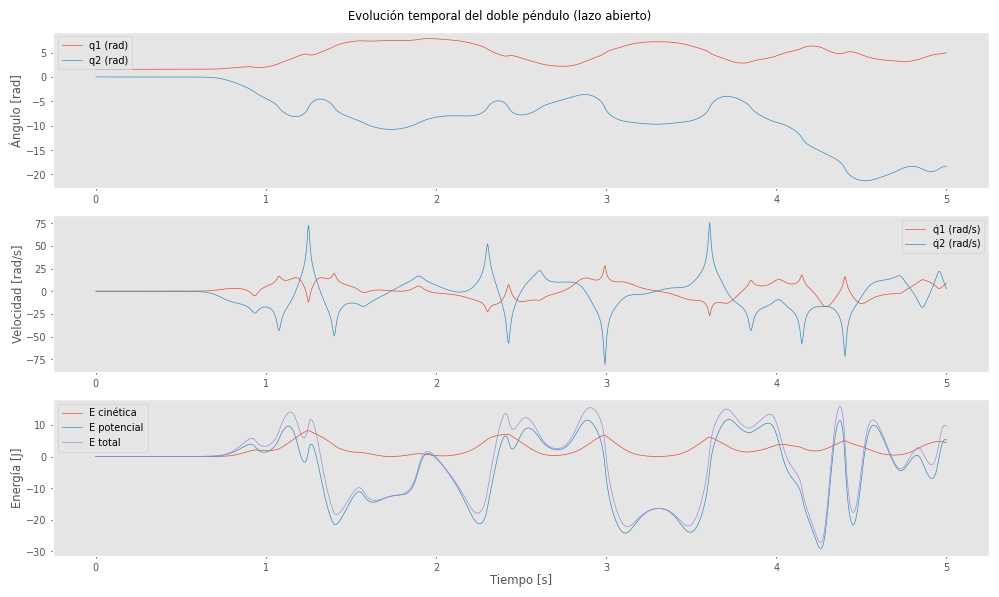

In [100]:
# --- Gráficos de evolución temporal ---
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(t, q1, label='q1 (rad)')
plt.plot(t, q2, label='q2 (rad)')
plt.ylabel('Ángulo [rad]')
plt.legend(); plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, qd1, label='q̇1 (rad/s)')
plt.plot(t, qd2, label='q̇2 (rad/s)')
plt.ylabel('Velocidad [rad/s]')
plt.legend(); plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, E_kin, label='E cinética')
plt.plot(t, E_pot, label='E potencial')
plt.plot(t, E_tot, label='E total')
plt.xlabel('Tiempo [s]')
plt.ylabel('Energía [J]')
plt.legend(); plt.grid()

plt.suptitle('Evolución temporal del doble péndulo (lazo abierto)')
plt.tight_layout()
plt.show()


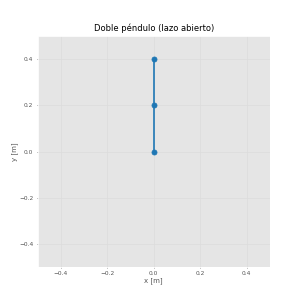

In [101]:
# ======================================
# ANIMACIÓN - DOBLE PÉNDULO (GIF)
# ======================================
from matplotlib.animation import FuncAnimation
from IPython.display import Image

# --- Calcular posiciones de los eslabones ---
a1, a2 = 0.2, 0.2
x1 = a1 * np.cos(q1)
y1 = a1 * np.sin(q1)
x2 = x1 + a2 * np.cos(q1 + q2)
y2 = y1 + a2 * np.sin(q1 + q2)

# --- Crear figura ---
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Doble péndulo (lazo abierto)')
line, = ax.plot([], [], 'o-', lw=2, color='tab:blue')
trace, = ax.plot([], [], '-', lw=1, color='tab:orange', alpha=0.5)  # traza de la punta
trace_x, trace_y = [], []

# --- Función de actualización por frame ---
def update(i):
    # puntos del péndulo
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]
    line.set_data(thisx, thisy)
    # traza de la punta del último eslabón
    trace_x.append(x2[i])
    trace_y.append(y2[i])
    trace.set_data(trace_x, trace_y)
    return line, trace

# --- Crear animación ---
step = 3  # usar un frame cada 5 muestras
frames = range(0, len(t), step)
ani = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)


# --- Guardar como GIF ---
gif_filename = "doble_pendulo.gif"
ani.save(gif_filename, writer='pillow', fps=30, dpi=60)

plt.close(fig)  # cerrar la figura para que no se muestre el frame estático

# --- Mostrar GIF en la notebook ---
Image(filename=gif_filename)
